In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette("Set2")
%matplotlib inline

Load dataset

In [2]:
df = pd.read_csv("with_olymp_db.csv", index_col="id")

`success` = учится ли человек

`fail` = отчислен ли человек

In [3]:
df["success"] = df.expulsion_sem.isnull()
df["fail"] = ~df["success"]
df

,admission_year,admission_condition,exam_math,exam_inf,exam_rus,individual_achievements,exam_sum,student_mark_math,student_mark_inf,expulsion_sem,gpa_after_first_sem,gpa_after_second_sem,retakes_number_after_first_sem,retakes_number_after_second_sem,math_olymp_100,inf_olymp_100,math_olymp_bvi,inf_olymp_bvi,success,fail
id,,,,,,,,,,,,,,,,,,,,
0,2017,БВИ,88.0,100.0,88.0,10.0,310.0,9.0,NaN,NaN,7.17,6.53,NaN,NaN,0,1,0,1,True,False
1,2017,БВИ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,7.93,NaN,NaN,0,1,0,1,True,False
2,2017,БВИ,98.0,94.0,86.0,4.0,NaN,NaN,NaN,NaN,9.17,8.73,NaN,NaN,1,0,1,0,True,False
3,2017,БВИ,84.0,84.0,72.0,6.0,NaN,9.0,8.0,NaN,7.00,7.50,NaN,NaN,1,0,1,0,True,False
4,2017,БВИ,96.0,100.0,91.0,10.0,NaN,8.0,10.0,NaN,9.17,8.87,NaN,NaN,0,1,0,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,2019,Контракт,86.0,84.0,89.0,8.0,283.0,4.0,8.0,NaN,5.14,6.35,1.0,NaN,0,0,0,0,True,False
309,2019,Контракт,92.0,91.0,94.0,4.0,281.0,8.0,3.0,NaN,6.29,6.29,NaN,NaN,0,0,0,0,True,False
310,2019,Контракт,88.0,91.0,89.0,10.0,278.0,4.0,4.0,1.0,NaN,NaN,NaN,NaN,1,0,0,0,False,True


In [4]:
def draw_hist(column_name, **kwargs):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    if "title" in kwargs:
        fig.suptitle(kwargs["title"])
    min_year = df.admission_year.min()
    years_cnt = df.admission_year.max() - min_year
    if "ylabel" in kwargs:
        axes[0].set_ylabel(kwargs["ylabel"])
    for i in range(years_cnt + 1):
        axes[i].hist(
            df.loc[df.success & (df.admission_year == min_year + i), column_name].dropna().to_numpy(), 
            bins=10,
            alpha=0.5,
            label="Success",
            density=True
        )
        axes[i].hist(
            df.loc[df.fail & (df.admission_year == min_year + i), column_name].dropna().to_numpy(),
            bins=10,
            alpha=0.5,
            label="Fail",
            density=True
        )
        axes[i].set_title(str(min_year + i))
        if "xlabel" in kwargs:
            axes[i].set_xlabel(kwargs["xlabel"])
        axes[i].legend()
    plt.savefig(kwargs["title"] + ".png", dpi=300)
    plt.show()

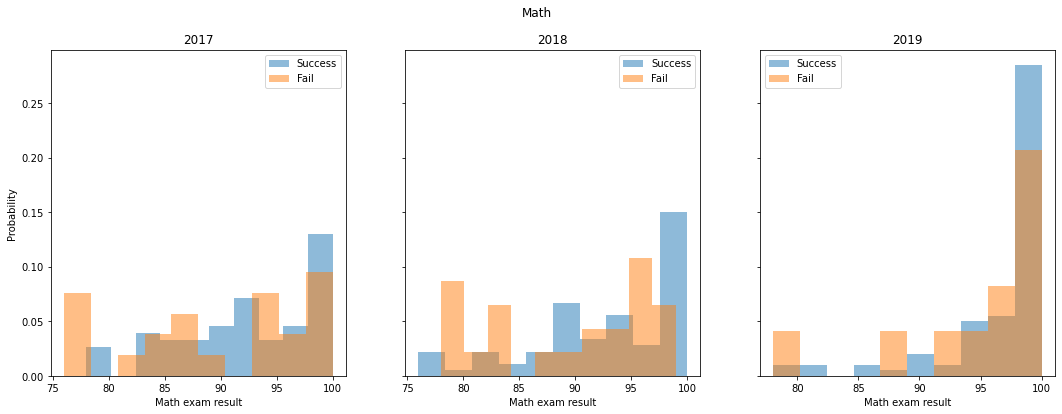

In [5]:
draw_hist("exam_math", title="Math", xlabel="Math exam result", ylabel="Probability")

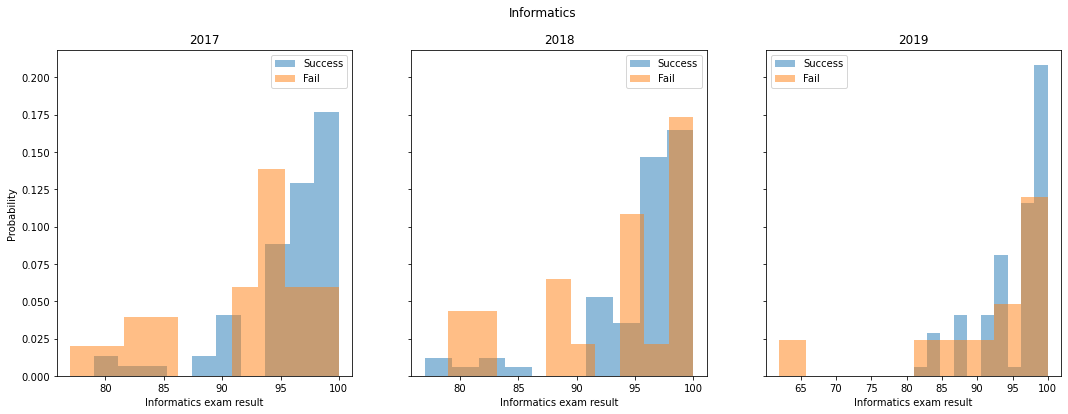

In [6]:
draw_hist("exam_inf", title="Informatics", xlabel="Informatics exam result", ylabel="Probability")

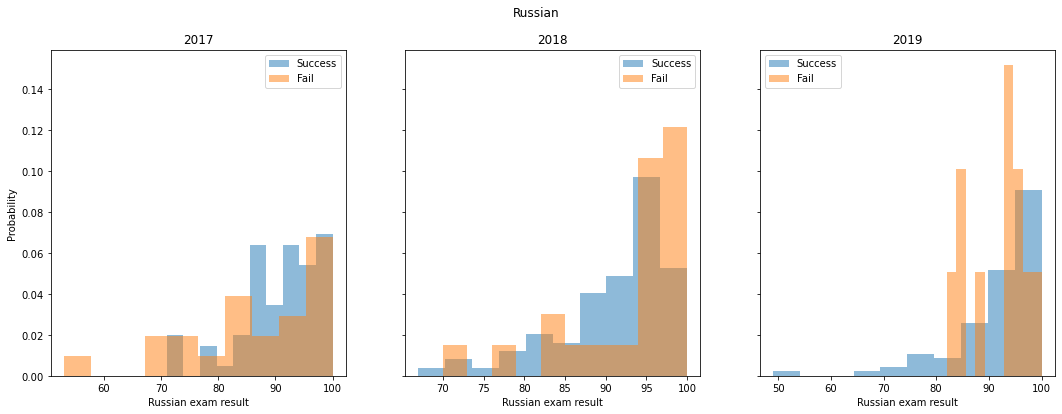

In [7]:
draw_hist("exam_rus", title="Russian", xlabel="Russian exam result", ylabel="Probability")

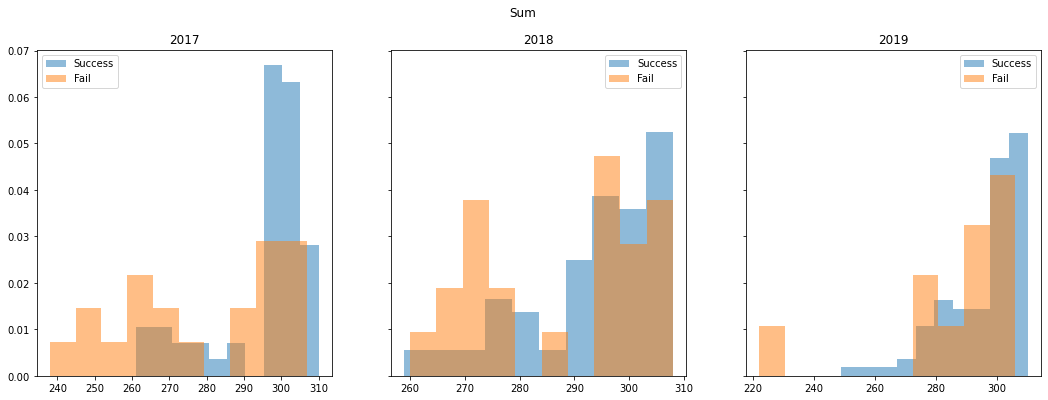

In [8]:
draw_hist("exam_sum", title="Sum")

# Models

In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
import sklearn.metrics as metrics

In [10]:
df["good_admission_condition"] = df.admission_condition.isin(["БВИ", "Общий конкурс", "ОК", "Грант"]).astype(np.int16)
df["bad_admission_condition"] = 1 - df["good_admission_condition"]

In [11]:
df

,admission_year,admission_condition,exam_math,exam_inf,exam_rus,individual_achievements,exam_sum,student_mark_math,student_mark_inf,expulsion_sem,...,retakes_number_after_first_sem,retakes_number_after_second_sem,math_olymp_100,inf_olymp_100,math_olymp_bvi,inf_olymp_bvi,success,fail,good_admission_condition,bad_admission_condition
id,,,,,,,,,,,,,,,,,,,,,
0,2017,БВИ,88.0,100.0,88.0,10.0,310.0,9.0,NaN,NaN,...,NaN,NaN,0,1,0,1,True,False,1,0
1,2017,БВИ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,1,0,1,True,False,1,0
2,2017,БВИ,98.0,94.0,86.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1,0,1,0,True,False,1,0
3,2017,БВИ,84.0,84.0,72.0,6.0,NaN,9.0,8.0,NaN,...,NaN,NaN,1,0,1,0,True,False,1,0
4,2017,БВИ,96.0,100.0,91.0,10.0,NaN,8.0,10.0,NaN,...,NaN,NaN,0,1,0,1,True,False,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,2019,Контракт,86.0,84.0,89.0,8.0,283.0,4.0,8.0,NaN,...,1.0,NaN,0,0,0,0,True,False,0,1
309,2019,Контракт,92.0,91.0,94.0,4.0,281.0,8.0,3.0,NaN,...,NaN,NaN,0,0,0,0,True,False,0,1
310,2019,Контракт,88.0,91.0,89.0,10.0,278.0,4.0,4.0,1.0,...,NaN,NaN,1,0,0,0,False,True,0,1


In [12]:
expulsion = df.expulsion_sem.fillna(0).astype(np.int16)
expulsion.loc[expulsion > 3] = 0

In [13]:
features = [
    "exam_math",
    "exam_inf",
    "exam_rus",
    "individual_achievements",
    "student_mark_math",
    "student_mark_inf",
    'math_olymp_100',
    'inf_olymp_100', 
    'math_olymp_bvi', 
    'inf_olymp_bvi',
    'good_admission_condition'
]
cat_features = [
    'math_olymp_100',
    'inf_olymp_100', 
    'math_olymp_bvi', 
    'inf_olymp_bvi',
    'good_admission_condition'
]
not_cat_features = [
    "exam_math",
    "exam_inf",
    "exam_rus",
    "individual_achievements",
    "student_mark_math",
    "student_mark_inf"
]

Fill `NaN` in feature columns

In [14]:
X = df[features]
y = pd.Series(~df.expulsion_sem.isnull(), dtype=np.int16)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [15]:
mean_val = dict()
X_filled = X.copy()
for feature in features:
    mean_val[feature] = X_filled[feature].dropna().mean()
    print(f"{feature}: {X_filled[feature].isnull().sum()} missing values")
    X_filled.loc[X_filled[feature].isnull(), feature] = mean_val[feature]

exam_math: 22 missing values
exam_inf: 23 missing values
exam_rus: 22 missing values
individual_achievements: 23 missing values
student_mark_math: 113 missing values
student_mark_inf: 119 missing values
math_olymp_100: 0 missing values
inf_olymp_100: 0 missing values
math_olymp_bvi: 0 missing values
inf_olymp_bvi: 0 missing values
good_admission_condition: 0 missing values


Prepare normalized data, calc mean and standard deviation among all feature columns

In [16]:
X_filled_train, X_filled_test, y_filled_train, y_filled_test = train_test_split(
    X_filled, y, test_size=0.2, stratify=y, random_state=69)

In [17]:
X_train_norm = pd.DataFrame(data=StandardScaler().fit_transform(X_filled_train[not_cat_features]), columns=not_cat_features)
X_test_norm = pd.DataFrame(data=StandardScaler().fit_transform(X_filled_test[not_cat_features]), columns=not_cat_features)
X_train_norm[cat_features] = X_filled_train.reset_index()[cat_features]
X_test_norm[cat_features] = X_filled_test.reset_index()[cat_features]

In [18]:
def run_cross_validation(clf, X=None, y=None):
    if X is None:
        X = X_test_norm
    if y is None:
        y = y_filled_test
    print("Test score:")
    print(f"Precision: {metrics.precision_score(y, clf.predict(X)):.4f}")
    print(f"Recall: {metrics.recall_score(y, clf.predict(X)):.4f}")
    print(f"f1: {metrics.f1_score(y, clf.predict(X)):.4f}")


def pipeline(clf, params, scoring='f1'):
    grid_clf = GridSearchCV(clf, params, scoring=scoring)
    grid_clf = grid_clf.fit(X_train_norm, y_filled_train)
    run_cross_validation(grid_clf.best_estimator_)
    return grid_clf.best_estimator_

# 1. Linear model

In [19]:
from sklearn.linear_model import LogisticRegression

Выбираем параметры перебором

`penalty`: тип регуляризации

`C`: коэффициент перед регуляризатором

`class_weight`: веса классов обратно пропорциональны их частоте (это нужно, так как отчисленных мало, классы неравноправны)

In [20]:
params = {
    'penalty': ('l2', 'l1'),
    'C': (1, 5, 10, 100, 200, 500, 1000, 2000, 5000),
    'class_weight': ('balanced', None),
    'max_iter': (500, 1000, 10000, 50000)
}

In [21]:
logreg = pipeline(
    LogisticRegression(solver="liblinear", max_iter=50000),
    params
)

Test score:
Precision: 0.3750
Recall: 0.7500
f1: 0.5000


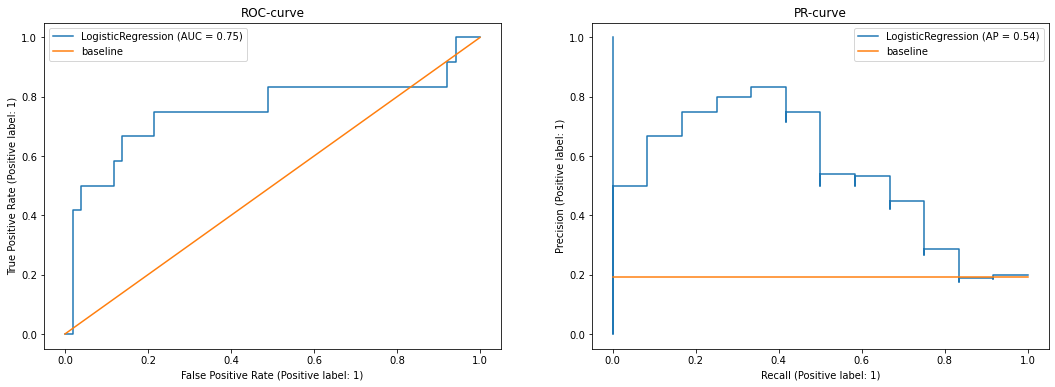

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
metrics.plot_roc_curve(logreg, X_test_norm, y_filled_test, ax=ax[0])
ax[0].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label="baseline")
ax[0].set_title("ROC-curve")
ax[0].legend()
metrics.plot_precision_recall_curve(logreg, X_test_norm, y_filled_test, ax=ax[1])
ax[1].set_title("PR-curve")
ax[1].plot(np.linspace(0, 1, 100), np.full(100, (y_test == 1).mean()), label="baseline")
ax[1].legend()
plt.savefig("logreg.png", dpi=300)
plt.show()

In [23]:
pd.DataFrame(logreg.coef_, columns=features).T

,0
exam_math,-0.146716
exam_inf,-0.401687
exam_rus,-0.108559
individual_achievements,-0.285048
student_mark_math,-0.137016
student_mark_inf,-0.218957
math_olymp_100,0.441065
inf_olymp_100,-1.984152
math_olymp_bvi,0.401741
inf_olymp_bvi,0.000000


In [24]:
logreg

LogisticRegression(C=1, class_weight='balanced', max_iter=500, penalty='l1',
                   solver='liblinear')

### Multiclass

In [25]:
def pipeline_multiclass(clf, params, X, y, scoring):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    grid_clf = GridSearchCV(clf, params, scoring=scoring)
    grid_clf.fit(X_train, y_train)
    return grid_clf.best_estimator_, X_test, y_test

In [26]:
params = {
    'penalty': ('l2', 'l1'),
    'C': (1, 5, 10, 100, 200, 500, 1000, 2000, 5000),
    'class_weight': ('balanced', None),
    'max_iter': (500, 1000, 10000, 50000)
}

In [27]:
multiclass_logreg, X_multiclass_logreg_test, y_multiclass_logreg_test = pipeline_multiclass(
    LogisticRegression(solver="liblinear", max_iter=1000),
    params,
    X_filled,
    expulsion,
    "f1_macro"
)

In [28]:
y_pred = multiclass_logreg.predict(X_multiclass_logreg_test)

In [29]:
print(f"f1_macro: {metrics.f1_score(y_multiclass_logreg_test, y_pred, average='macro'):.4f}")
print(f"precision_macro: {metrics.precision_score(y_multiclass_logreg_test, y_pred, average='macro'):.4f}")
print(f"recall_macro: {metrics.recall_score(y_multiclass_logreg_test, y_pred, average='macro'):.4f}")

f1_macro: 0.2227
precision_macro: 0.2227
recall_macro: 0.2227


In [30]:
multiclass_logreg

LogisticRegression(C=200, class_weight='balanced', max_iter=500,
                   solver='liblinear')

# 2. Gradient Boosting

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

In [34]:
params = {
    'loss': ('deviance', 'exponential'),
    'learning_rate': (0.1, 0.03),
    'n_estimators': (100, 500),
    'min_samples_split': (2, 5, 7),
    'max_depth': (1, 5, 9)
}

In [35]:
boosting = pipeline(
    GradientBoostingClassifier(warm_start=True, random_state=42, max_features='sqrt'),
    params
)

Test score:
Precision: 0.3750
Recall: 0.2500
f1: 0.3000


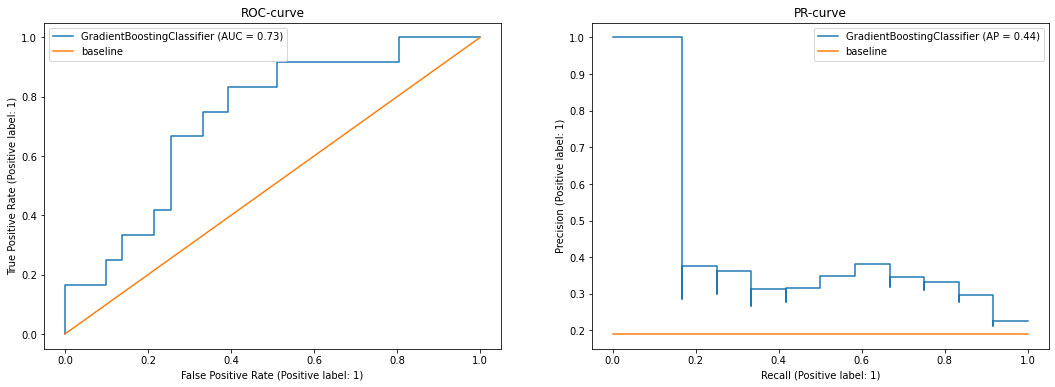

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
metrics.plot_roc_curve(boosting, X_test_norm, y_filled_test, ax=ax[0])
ax[0].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label="baseline")
ax[0].set_title("ROC-curve")
ax[0].legend()
metrics.plot_precision_recall_curve(boosting, X_test_norm, y_filled_test, ax=ax[1])
ax[1].set_title("PR-curve")
ax[1].plot(np.linspace(0, 1, 100), np.full(100, (y_test == 1).mean()), label="baseline")
ax[1].legend()
plt.savefig("gradient_boosting.png", dpi=300)
plt.show()

In [38]:
boosting.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'exponential',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': True}

### Multiclass

In [39]:
params = {
    'learning_rate': (0.1, 0.03),
    'n_estimators': (100,),
    'min_samples_split': (2, 5),
    'max_depth': (1, 6),
    'max_features': ('auto', 'sqrt', 'log2')
}

In [40]:
multiclass_boosting, X_multiclass_boosting_test, y_multiclass_boosting_test = pipeline_multiclass(
    GradientBoostingClassifier(warm_start=True, random_state=42, loss='deviance'),
    params,
    X_filled,
    expulsion,
    "f1_macro"
)

In [41]:
y_pred = multiclass_boosting.predict(X_multiclass_boosting_test)
print(f"f1_macro: {metrics.f1_score(y_multiclass_boosting_test, y_pred, average='macro'):.4f}")
print(f"precision_macro: {metrics.precision_score(y_multiclass_boosting_test, y_pred, average='macro'):.4f}")
print(f"recall_macro: {metrics.recall_score(y_multiclass_boosting_test, y_pred, average='macro'):.4f}")

f1_macro: 0.2331
precision_macro: 0.2183
recall_macro: 0.2500


/usr/local/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
multiclass_boosting

GradientBoostingClassifier(learning_rate=0.03, max_depth=6, max_features='sqrt',
                           min_samples_split=5, random_state=42,
                           warm_start=True)

# 3. Catboost

In [ ]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=list(range(6, 11)), has_header=True)
test_pool = Pool(X_test, y_test, cat_features=list(range(6, 11)), has_header=True)
grid = {
    'learning_rate': [0.003, 0.03, 0.1],
    'depth': [1, 3, 5, 9],
    'l2_leaf_reg': [1, 5, 9],
    'iterations': [100, 500, 1000, 2000]
}

In [ ]:
catboost_model = CatBoostClassifier(logging_level="Silent", eval_metric="F1")
grid_search_result = catboost_model.grid_search(grid,
                                                X=train_pool,
                                                stratified=True,
                                                verbose=False)

In [ ]:
print("Test score:")
print(f"Precision: {precision_score(y_test, catboost_model.predict(X_test)):.4f}")
print(f"Recall: {recall_score(y_test, catboost_model.predict(X_test)):.4f}")
print(f"f1: {f1_score(y_test, catboost_model.predict(X_test)):.4f}")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_roc_curve(catboost_model, X_test, y_test, ax=ax)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label="baseline")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_precision_recall_curve(catboost_model, X_test, y_test, ax=ax)
plt.plot(np.linspace(0, 1, 100), np.full(100, (y_test == 1).mean()), label="baseline")
plt.legend()
plt.show()

In [ ]:
catboost_model.get_params()

# 4. TorchNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_curve, auc, roc_auc_score
from tqdm import trange

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 11
        hidden_size = 1000
        output_size = 2
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.fc7 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x

net = Model()

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.SGD(net.parameters(), lr=0.003)

In [ ]:
X_train_nn = torch.tensor(X_train_norm.to_numpy(), dtype=torch.float)
X_test_nn = torch.tensor(X_test_norm.to_numpy(), dtype=torch.float)
y_train_nn = torch.tensor(y_filled_train.to_numpy(), dtype=torch.long)
y_test_nn = torch.tensor(y_filled_test.to_numpy(), dtype=torch.long)

In [ ]:
train_losses = []
test_losses = []
for epoch in trange(1000):
    optimizer.zero_grad()
    y_pred = net(X_train_nn)
    train_loss = criterion(y_pred, y_train_nn)
    train_losses.append(train_loss.item())
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    with torch.no_grad():
        test_losses.append(criterion(net(X_test_nn), y_test_nn).item())

In [ ]:
plt.figure(figsize=(12, 8))
grid = np.arange(1, 1 + len(test_losses))
plt.plot(
    grid,
    train_losses,
    label="train loss"
)
plt.plot(
    grid,
    test_losses,
    label="test loss"
)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
y_pred = nn.Softmax(dim=1)(net(X_test_nn)).argmax(dim=1).numpy()

In [ ]:
print("Test score:")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"f1: {f1_score(y_test, y_pred):.4f}")

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(fpr, tpr, label=f"NN (AUC = {round(auc(fpr, tpr), 2)})")
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label="baseline")
plt.legend()
plt.show()

# 5. PCA

In [43]:
from sklearn.decomposition import PCA

In [44]:
pca = PCA(7).fit(X_train_norm)
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

In [45]:
params = {
    'penalty': ('l2', 'l1'),
    'C': (1, 5, 10, 100, 200, 500, 1000, 2000, 5000),
    'class_weight': ('balanced', None)
}

In [46]:
grid_clf = GridSearchCV(LogisticRegression(solver="liblinear", max_iter=50000), params, scoring="f1")
grid_clf = grid_clf.fit(X_train_pca, y_filled_train)

In [47]:
clf = grid_clf.best_estimator_

In [48]:
print("Test score:")
print(f"Precision: {metrics.precision_score(y_filled_test, clf.predict(X_test_pca)):.4f}")
print(f"Recall: {metrics.recall_score(y_filled_test, clf.predict(X_test_pca)):.4f}")
print(f"f1: {metrics.f1_score(y_filled_test, clf.predict(X_test_pca)):.4f}")

Test score:
Precision: 0.4545
Recall: 0.8333
f1: 0.5882


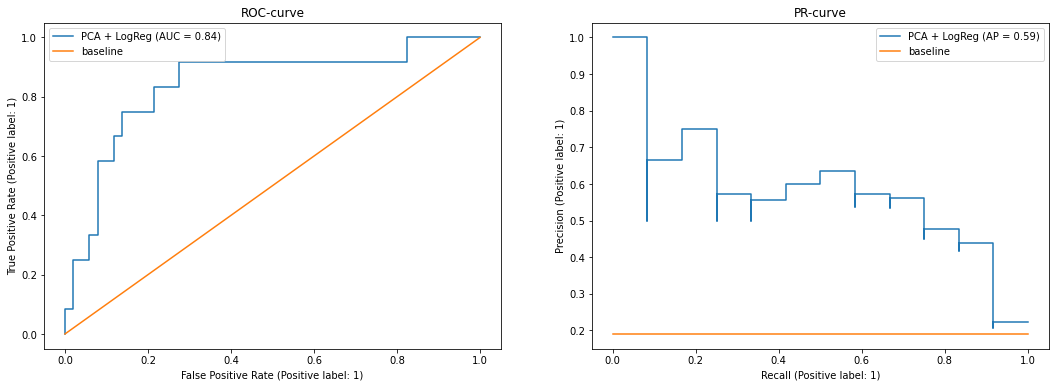

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
metrics.plot_roc_curve(
    clf, X_test_pca, y_filled_test, ax=ax[0], 
    label=f"PCA + LogReg (AUC = {metrics.roc_auc_score(y_filled_test, clf.predict_proba(X_test_pca)[:, -1]):.2f})"
)
ax[0].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label="baseline")
ax[0].set_title("ROC-curve")
ax[0].legend()
metrics.plot_precision_recall_curve(
    clf, X_test_pca, y_filled_test, ax=ax[1], 
    label=f"PCA + LogReg (AP = {metrics.average_precision_score(y_filled_test, clf.predict_proba(X_test_pca)[:, -1]):.2f})")
ax[1].set_title("PR-curve")
ax[1].plot(np.linspace(0, 1, 100), np.full(100, (y_test == 1).mean()), label="baseline")
ax[1].legend()
plt.savefig("pca_logreg.png", dpi=300)
plt.show()

In [50]:
clf

LogisticRegression(C=1, class_weight='balanced', max_iter=50000, penalty='l1',
                   solver='liblinear')

# 6. kNN

In [51]:
from sklearn.neighbors import KNeighborsClassifier

In [52]:
params = {
    'n_neighbors': (1, 2, 3, 4, 5)
}

In [53]:
knn = pipeline(
    KNeighborsClassifier(),
    params
)

Test score:
Precision: 0.3333
Recall: 0.3333
f1: 0.3333


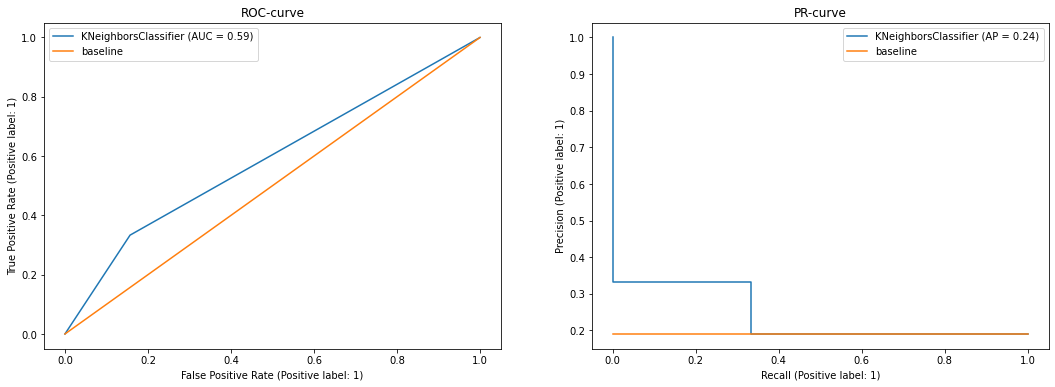

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
metrics.plot_roc_curve(knn, X_test_norm, y_filled_test, ax=ax[0])
ax[0].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label="baseline")
ax[0].set_title("ROC-curve")
ax[0].legend()
metrics.plot_precision_recall_curve(knn, X_test_norm, y_filled_test, ax=ax[1])
ax[1].set_title("PR-curve")
ax[1].plot(np.linspace(0, 1, 100), np.full(100, (y_test == 1).mean()), label="baseline")
ax[1].legend()
plt.savefig("gradient_boosting.png", dpi=300)
plt.show()

In [55]:
knn

KNeighborsClassifier(n_neighbors=1)

# 7. Overview

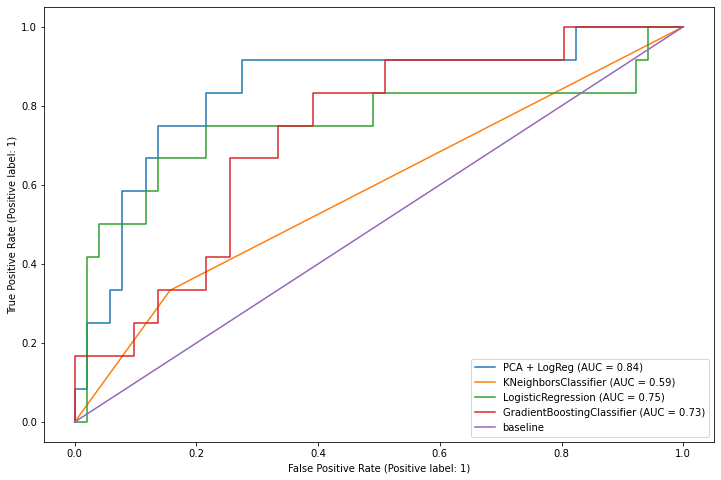

In [56]:
fig, ax = plt.subplots(figsize=(12, 8))
metrics.plot_roc_curve(
    clf, X_test_pca, y_filled_test, ax=ax,
    label=f"PCA + LogReg (AUC = {metrics.roc_auc_score(y_filled_test, clf.predict_proba(X_test_pca)[:, -1]):.2f})"
)
metrics.plot_roc_curve(knn, X_test_norm, y_filled_test, ax=ax)
metrics.plot_roc_curve(logreg, X_test_norm, y_filled_test, ax=ax)
metrics.plot_roc_curve(boosting, X_test_norm, y_filled_test, ax=ax)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label="baseline")
plt.legend()
plt.savefig("all_roc.png", dpi=300)
plt.show()

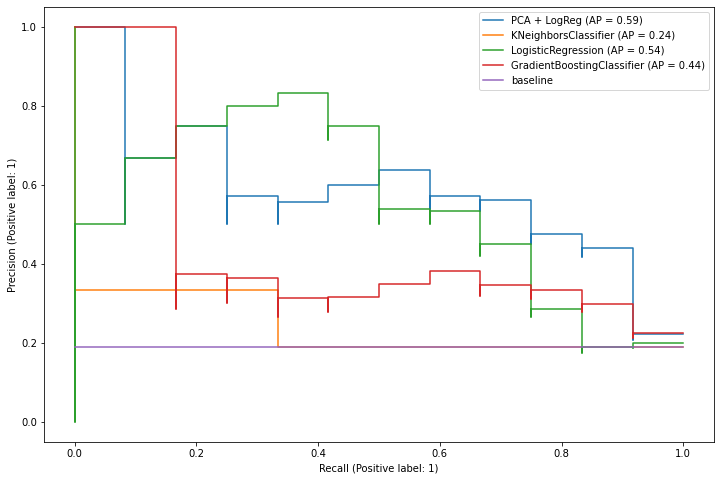

In [57]:
fig, ax = plt.subplots(figsize=(12, 8))
metrics.plot_precision_recall_curve(
    clf, X_test_pca, y_filled_test, ax=ax,
    label=f"PCA + LogReg (AP = {metrics.average_precision_score(y_filled_test, clf.predict_proba(X_test_pca)[:, -1]):.2f})"
)
metrics.plot_precision_recall_curve(knn, X_test_norm, y_filled_test, ax=ax)
metrics.plot_precision_recall_curve(logreg, X_test_norm, y_filled_test, ax=ax)
metrics.plot_precision_recall_curve(boosting, X_test_norm, y_filled_test, ax=ax)
plt.plot(np.linspace(0, 1, 100), np.full(100, (y_filled_test == 1).mean()), label="baseline")
plt.legend()
plt.savefig("all_pr.png", dpi=300)
plt.show()

In [61]:
from pickle import dump
with open("web/pca", 'wb') as file:
    dump(pca, file)
with open("web/logreg", 'wb') as file:
    dump(clf, file)